In [1]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18

def load_data(path, fname='interp_between_1.npy'):
    wavelength, flux, err = load_binned_data(os.path.join(path,fname))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')
distance = (9.72*units.pc).to(units.cm)

## Flares in the 30s data

In [2]:
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w30, w20, axis=0), 
                    flux=np.append(f30, f20, axis=0),
                    flux_err=np.append(e30, e20, axis=0), 
                    time=np.append(t30, t20)-t30[0], 
                    orbit=np.append(o30, o20+5))

fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/belugawhale/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [3]:
%load_ext autoreload
%autoreload 2
from plot_utils import make_tworow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
visit2_time = np.append(t30,t20)-t20[0]

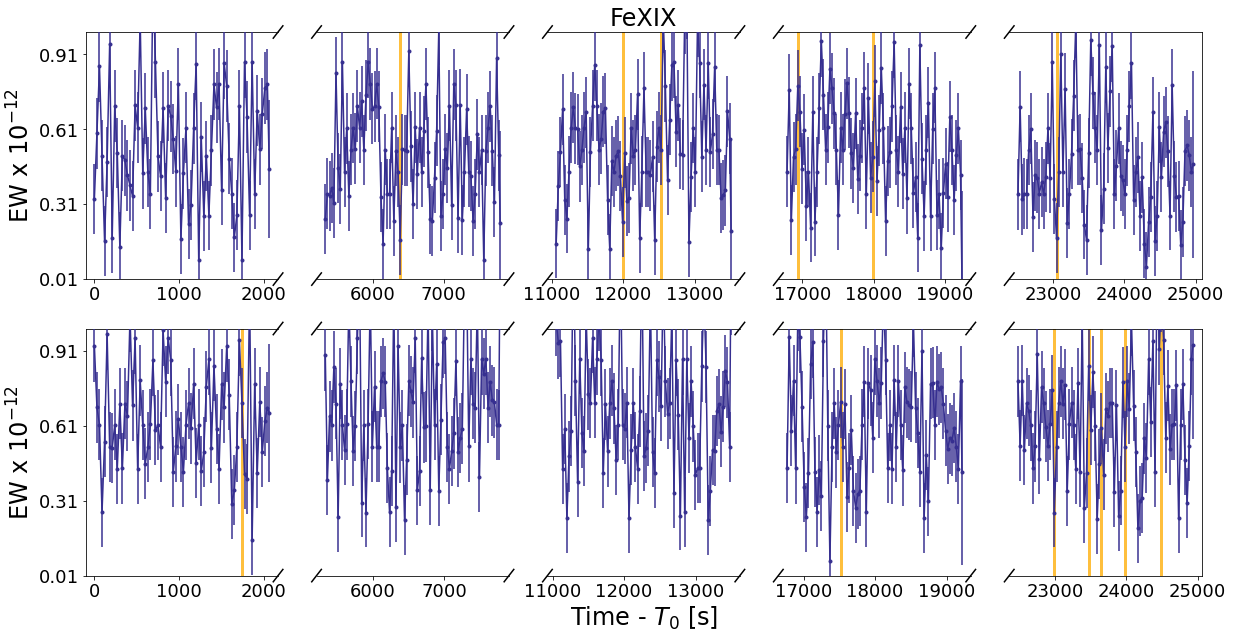

In [5]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[0]].data[q], 
                     yerr=fwc.error_table[iron[0]].data[q]/10,
                     marker='.',  color=parula[3], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[0], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXIX.png', dpi=250,
#            rasterize=True, bbox_inches='tight')

# If flare mask created, start below

In [7]:
_, which_o, f_int = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                            allow_pickle=True)

In [8]:
def multi_peaks(ttest, test):
    """
    test = time
    ttest = flux
    """

    #plt.plot(ttest, test-test.min(),'k')
    #plt.plot(ttest, test-test.min(), '.')

    p1 = np.argmax(test)
    #plt.plot(ttest[p1], test[p1], 'ro')
    
    try:
        arg = np.where((ttest.value>ttest[p1].value+100))[0]
        p2 = np.argmax(test[arg])
        #plt.plot(ttest[arg][p2], test[arg][p2], 'bo')
    except:
        arg=np.arange(0,len(ttest),1,dtype=int)
        p2=0
        
    try:
        arg3 = np.where((ttest.value>ttest[arg][p2].value+100))[0]
        p3 = np.argmax(test[arg3])
        #plt.plot(ttest[arg3][p3], test[arg3][p3], 'ko')

    except:
        arg3=np.arange(0,len(ttest),1,dtype=int)
        p3=0
        
    t0 = np.array([ttest[p1].value, ttest[arg][p2].value, ttest[arg3][p3].value])
    amp = np.array([test[p1], test[arg][p2], test[arg3][p3]])#/1e-13

    return t0, amp

## Broad band flares

In [10]:
ions = ['CII_10', 'SiIII', 'CIII','NV_1','FeXXI']

## Visit 1 Orbit 2 flares

In [13]:
ions = ['CII_11', 'SiIII', 'CIII','NV_1','FeXXI']

[35.11598492 27.5098884 ]


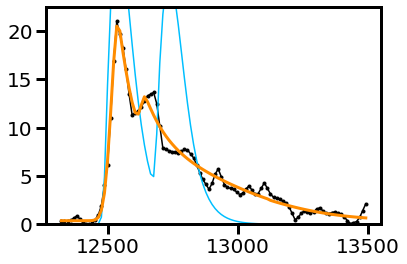

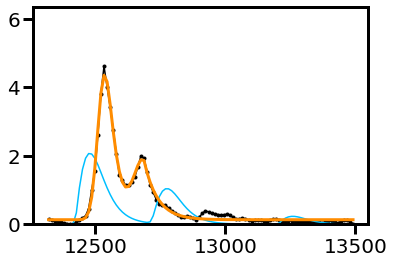

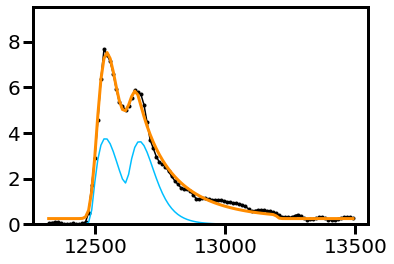

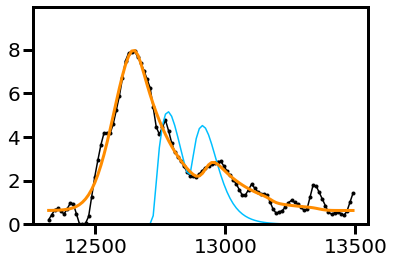

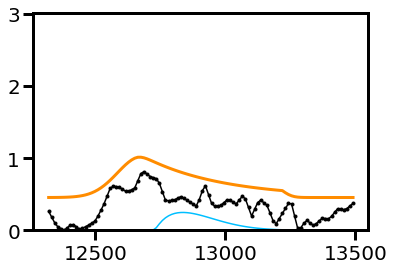

In [26]:
fmodels = []
scalings = []

mask = f_int[1] > 0
tmp1 = []

for ion in ions:

    upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
    
    if ion !='CIII':
        finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-12)
        einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-12)
        scaling=1e-12
    else:
        finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-11)
        einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-11)
        scaling=1e-11
    
    t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
    rise, decay = [10,10,10],[50,50,50] 
    
    y = finterp(upsample)-np.nanmin(finterp(upsample))
    plt.plot(upsample, 
             y,
             marker='.', color='k')
    
    if ion == 'SiIII':# or ion=='NV_1':
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0-30, omega=np.full(3,50), 
                            alpha=np.full(3,50),
                            amp=amp/scaling*10, t0=t0+300, rise=rise, decay=decay,
                            x=upsample.value, 
                            y=y,
                            yerr=einterp(upsample))
    elif ion == 'CII_11':
        t0[1]-=50
        print(amp[:2]/scaling)
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:2]-20, omega=np.full(2,50), 
                            alpha=np.full(2,50),
                            amp=amp[:2]/scaling*20, t0=t0[:2]+350, 
                            rise=rise[:2], decay=decay[:2],
                            x=upsample.value, 
                            y=y,
                            yerr=einterp(upsample))
    elif ion == 'CIII' or ion=='NV_1':
        t0[1]-=50
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:2]-20, omega=np.full(3,50), 
                            alpha=np.full(2,50),
                            amp=amp[:2]/scaling*10, t0=t0[:2]+350,
                            rise=rise, decay=decay,
                            x=upsample.value, y=y,
                            yerr=einterp(upsample))
    else:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:1]-20, omega=[150], alpha=[50],
                            amp=amp[:1]/1e-12*10,t0=t0[:1]+300, rise=rise[:1], decay=decay[:1],
                            x=upsample.value, y=finterp(upsample))#,
                            #yerr=einterp(upsample))
    plt.plot(upsample, out[-2], color='deepskyblue')
    plt.plot(upsample, out[-1].best_fit, color='darkorange', lw=3)
    plt.ylim(0, np.nanmax(out[-1].best_fit)+2)
    tmp1.append(out)
    plt.show()
    scalings.append(scaling)
fmodels.append(tmp1)

## Visit 2 Orbit 5 flares

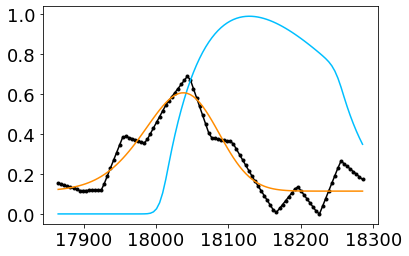

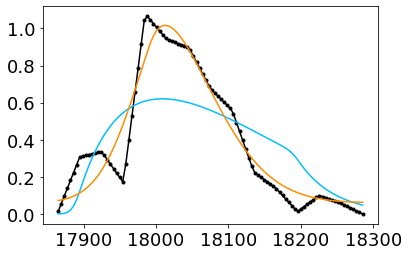

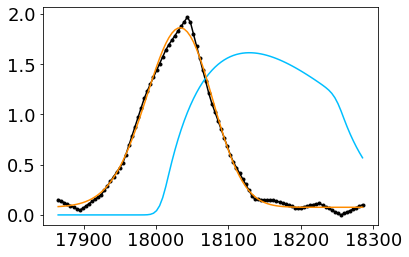

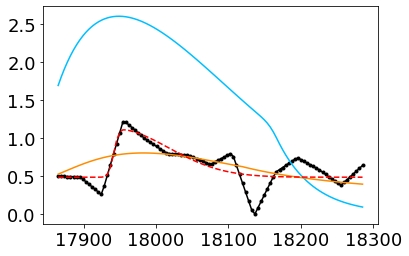

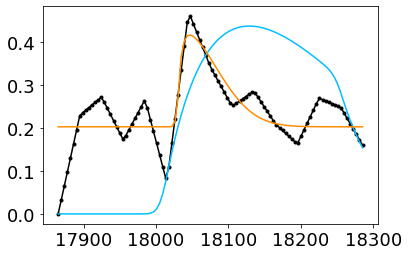

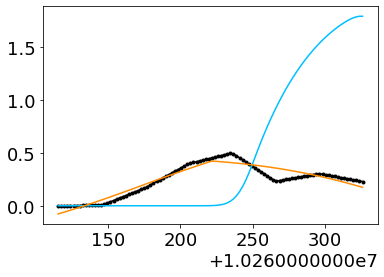

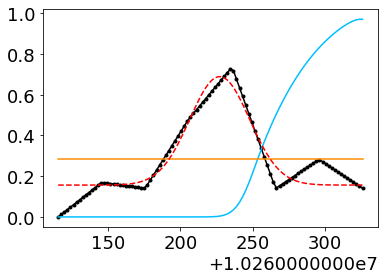

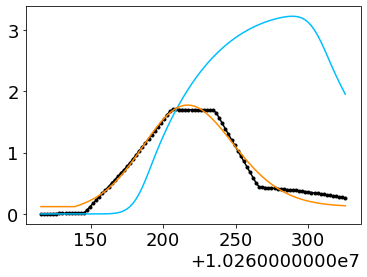

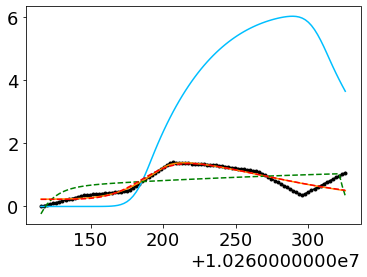

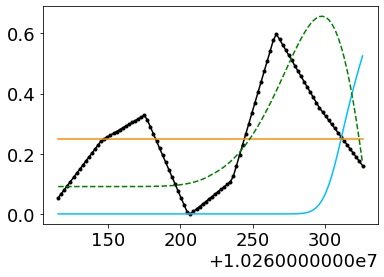

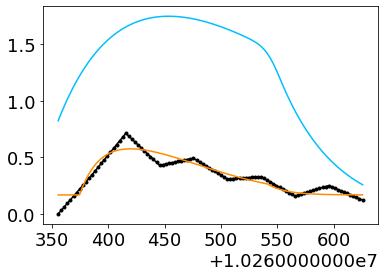

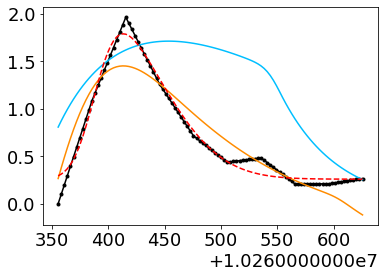

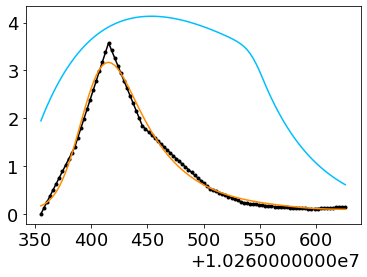

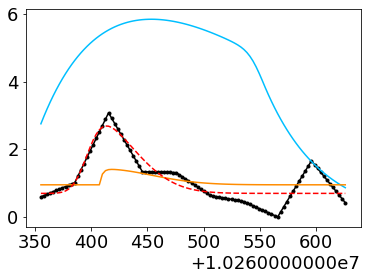

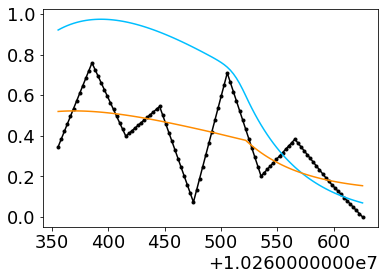

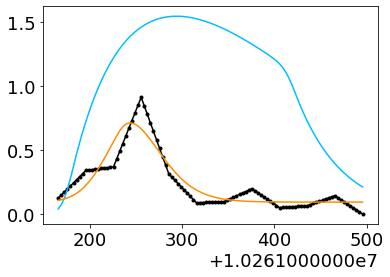

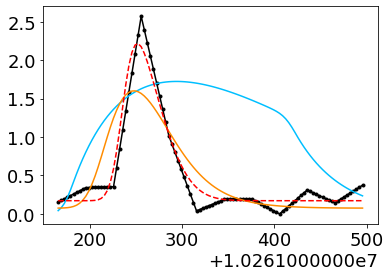

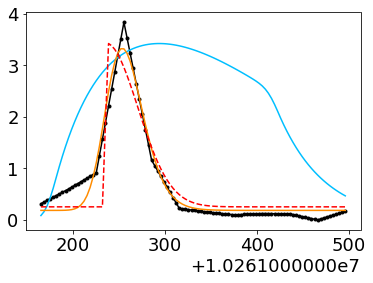

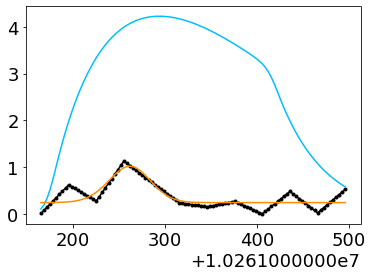

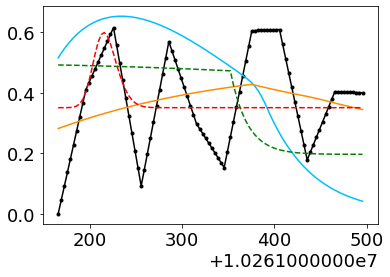

In [15]:
fmodels_25 = []
scalings_25 = []

for j in [3,-4,-3,-1]:
    temp_f = []
    temp_l = []
    temp_s = []
    mask = f_int[j] > 0
    
    for ion in ions:

        upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
        
        if 'CII' not in ion:
            finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-12)
            einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-12)
            scaling=1e-12
        else:
            finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-11)
            einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-11)
            scaling=1e-11

            
        y = finterp(upsample) - np.nanmin(finterp(upsample))
        plt.plot(upsample, y, 'k', marker='.')

        t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
            
        rise, decay = [10,10,10],[50,50,50] 

        out = fwc.fit_flare(ion=ion, mask=mask,  model='convolved',
                            eta=t0[:1], omega=[200], alpha=[100], offset=0.5,
                            amp=amp[:1]/scaling*10, t0=t0[:1], rise=[10], decay=[50],
                            x=upsample.value, y=y,
                            yerr=einterp(upsample))

        plt.plot(upsample, out[-2], color='deepskyblue')
        plt.plot(upsample, out[-1].best_fit, color='darkorange')

        if out[-1].chisqr > 2 and out[-1].chisqr <= 3:
            out = fwc.fit_flare(ion=ion, mask=mask,  model='convolved',
                            eta=t0[:1], omega=[200], alpha=[50], offset=1,
                            amp=amp[:1]/scaling*1000, t0=t0[:1], rise=[10], decay=[50],
                            x=upsample.value, y=y,
                            yerr=einterp(upsample))
            #plt.plot(upsample, out[-2], '--', color='yellow')
            plt.plot(upsample, out[-1].best_fit, '--', color='green')
        
        if out[-1].chisqr > 3:
            out = fwc.fit_flare(ion=ion, mask=mask,  model='skewed gaussian',
                            eta=t0[:1]-20, omega=[10], alpha=[20], offset=1,
                            amp=amp[:1]/scaling*10, t0=t0[:1]-20, rise=[5], decay=[50],
                            x=upsample.value, y=y,
                            yerr=einterp(upsample))
            #plt.plot(upsample, out[-2], '--', color='blue')
            plt.plot(upsample, out[-1].best_fit, '--', color='red')
        
        temp_f.append(out)
        plt.show()
        temp_s.append(scaling)

    fmodels_25.append(temp_f)
    scalings_25.append(temp_s)
    

In [16]:
def duration(zeroed, time):
    med = np.nanmedian(zeroed)
    qmask = zeroed<0.5*med
    fmask = zeroed>=0.5*med
    fq = np.nanmedian(zeroed[qmask])
    
    plt.plot(time[fmask], zeroed[fmask],'.')
    plt.plot(time[qmask], zeroed[qmask],'.')
    plt.show()
    return np.trapz(((zeroed[fmask]-fq)/fq),x=time[fmask]*units.s)

# Paper plots

In [107]:
COLOR = 'w'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70107/3938076077.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path,'models.png'), rasterize=True,


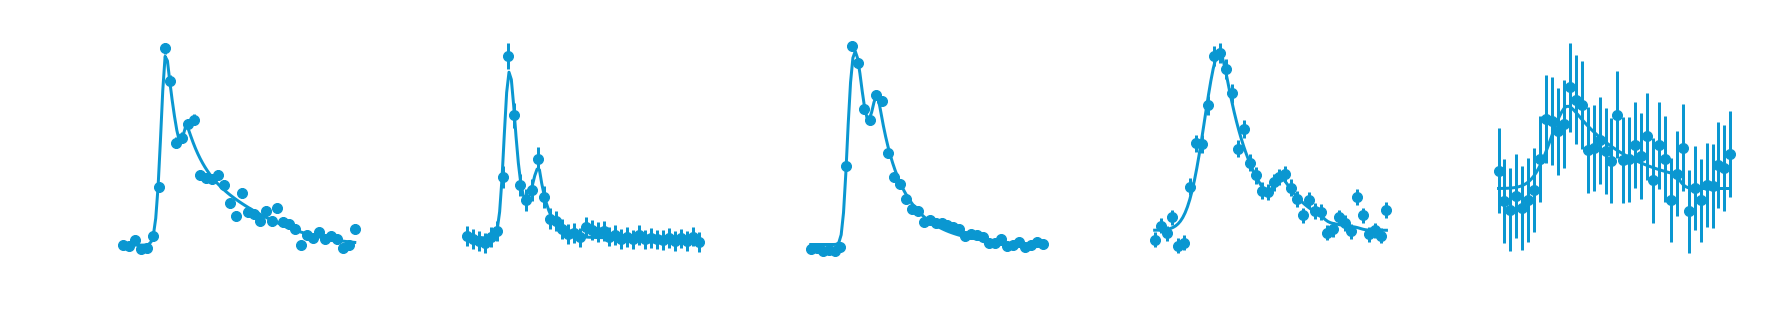

In [118]:
fig, (ax01, ax03, ax05, ax07, ax09) = plt.subplots(tight_layout=True, 
                                                   figsize=(25,5), 
                                                   ncols=5)

bigax = [ax01,ax03,ax05,ax07,ax09]

titles=['C II', 'Si III', 'C III', 'N V', 'Fe XXI']

if COLOR == 'k':
    ion_colors = parula[np.linspace(0,200,5,dtype=int)]
else:
    ion_colors = parula[np.linspace(80,230,5,dtype=int)]
    
formtemp = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
x = 0


for n in range(1):
    tempe = []
    tempd = []
    for i in range(5):
        mask = f_int[ind[n]] > 0
        qmask = f_int[ind[n]] == 0

        if i == 4:
            add=0.3
        else:
            add=0
        if 'CIII' not in ions[i]:
            bigax[i].plot(fmodels[n][i][0],
                      fmodels[n][i][-1].best_fit-add,#/1e12,
                      c=ion_colors[x], lw=3)
            fm = fmodels[n][i][-1].best_fit#/1e12

        else:
            bigax[i].plot(fmodels[n][i][0],
                      fmodels[n][i][-1].best_fit-add,#/1e11,
                      c=ion_colors[x], lw=3)
            fm = fmodels[n][i][-1].best_fit*10#/1e11

        y = fwc.width_table[ions[i]][mask]/scalings[i]

        bigax[i].errorbar(fwc.time[mask].value,
                          y-np.nanmin(y),
                          yerr=fwc.error_table[ions[i]][mask].value/scalings[i]/2, 
                          c=ion_colors[x], linestyle='', lw=3, marker='o', ms=10)

        bigax[i].set_title(titles[i], fontsize=24)

        if i == 3:
            bigax[i].set_title('NV', fontsize=24)

        bigax[i].set_xticks([12500, 13000, 13500])

        bigax[i].set_rasterized(True)


        zeroed = fm - np.nanmin(fm)
        e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                          x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
        _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                           flux=fwc.width_table[ions[i]])

        
    x += 1
    energies.append(tempe)
    durations.append(tempd)
    

ax01.set_ylabel('Flux\n[10$^{-12}$ erg s$^{-1}$ cm$^{-2}$]', fontsize=24, x=-0.2)
ax05.set_xlabel('MJD - 59362.148 [s]', fontsize=24)

plt.subplots_adjust(wspace=0.)

if COLOR=='k':
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/'
else:
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/dark-bkg/'
plt.savefig(os.path.join(path,'models.png'), rasterize=True,
            dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig('/Users/belugawhale/Documents/AUMic/paper/models.pdf', rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(25,12))
#fig.set_facecolor('w')
gs = gridspec.GridSpec(3,5, width_ratios=[3.5,3.5,3.5,3.5,3.5])
ax01 = fig.add_subplot(gs[0,0])
ax03 = fig.add_subplot(gs[0,1])
ax05 = fig.add_subplot(gs[0,2])
ax07 = fig.add_subplot(gs[0,4])
ax09 = fig.add_subplot(gs[0,3])

ax11 = fig.add_subplot(gs[1,0])
ax33 = fig.add_subplot(gs[1,1])
ax55 = fig.add_subplot(gs[1,2])
ax77 = fig.add_subplot(gs[1,4])
ax99 = fig.add_subplot(gs[1,3])

ax1 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[2,2])
ax7 = fig.add_subplot(gs[2,4])
ax9 = fig.add_subplot(gs[2,3])

#eax = fig.add_subplot(gs[0:,5:])

faxes = [ax1,ax3,ax5,ax9,ax7]
bigax = [ax01,ax03,ax05,ax09,ax07]
dax = [ax11,ax33,ax55,ax99,ax77]
#laxes = [ax2,ax4,ax6,ax8]

titles=['C II', 'Si III', 'C III', 'N V', 'Fe XXI']

if COLOR == 'k':
    ion_colors = parula[np.linspace(0,200,5,dtype=int)]
else:
    ion_colors = parula[np.linspace(80,230,5,dtype=int)]
    
formtemp = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
x = 0
ind = [1,3,-4,-3,-1]
energies = []
durations = []

xy = ax7.twinx()
xy.set_ylabel('Flares J, K, M', fontsize=30)
xy.set_yticks([])

xy = ax77.twinx()
xy.set_ylabel('Flare D', fontsize=30)
xy.set_yticks([])

xy = ax07.twinx()
xy.set_ylabel('Flare B', fontsize=30,x=3)
xy.set_yticks([])

n25=0

for n in range(len(fmodels_25)+1):
    tempe = []
    tempd = []
    for i in [0,1,2,3,4]:
        mask = f_int[ind[n]] > 0
        qmask = f_int[ind[n]] == 0

        if n == 0:
            if i == 4:
                add=0.3
            else:
                add=0
            if 'CIII' not in ions[i]:
                bigax[i].plot(fmodels[n][i][0],
                          fmodels[n][i][-1].best_fit-add,#/1e12,
                          c=ion_colors[x], lw=3)
                fm = fmodels[n][i][-1].best_fit#/1e12
                
            else:
                bigax[i].plot(fmodels[n][i][0],
                          fmodels[n][i][-1].best_fit-add,#/1e11,
                          c=ion_colors[x], lw=3)
                fm = fmodels[n][i][-1].best_fit*10#/1e11
                
            y = fwc.width_table[ions[i]][mask]/scalings[i]
            
            bigax[i].errorbar(fwc.time[mask].value,
                              y-np.nanmin(y),
                              yerr=fwc.error_table[ions[i]][mask].value/scalings[i]/2, 
                              c=ion_colors[x], linestyle='', lw=3, marker='o', ms=10)
            
            bigax[i].set_title(titles[i], fontsize=24)
            
            if i == 3:
                bigax[i].set_title('NV', fontsize=24)

            bigax[i].set_xticks([12500, 13000, 13500])
            
            bigax[i].set_xlabel('MJD - 59362.148 [s]')
            bigax[i].set_rasterized(True)
    
            
            zeroed = fm - np.nanmin(fm)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                               flux=fwc.width_table[ions[i]])
        
        else:
            if n == 1:
                xx = dax
                toffset=0
            else:
                xx = faxes
                toffset=fwc.time[402].value

            y = fwc.width_table[ions[i]][mask]/scalings_25[n-1][i]
            xx[i].errorbar(fwc.time[mask].value-toffset,
                              y-np.nanmin(y),
                              yerr=fwc.error_table[ions[i]][mask]/scalings_25[n-1][i]/2,
                              c=ion_colors[x], linestyle='', lw=3, marker='o',ms=10)
            
            if ions[i] != 'FeXXI':
                if 'CII' not in ions[i]:
                    if n == 1 and ions[i] == 'CII_11':
                        print('bad')
                        pass
                    else:
                        xx[i].plot(fmodels_25[n-1][i][0]-toffset,
                                      fmodels_25[n-1][i][-1].best_fit,#/1e12,
                                      c=ion_colors[x], lw=3)
                        fm = fmodels_25[n-1][i][-1].best_fit#/1e12
                else:
                    xx[i].plot(fmodels_25[n-1][i][0]-toffset,
                                  fmodels_25[n-1][i][-1].best_fit,#/1e11,
                                  c=ion_colors[x], lw=3)
                    fm = fmodels_25[n-1][i][-1].best_fit*10#/1e11


            zeroed = fm - np.nanmin(fm)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                          x=fmodels_25[n-1][i][0]*units.s)*4*np.pi*distance**2

            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                           flux=fwc.width_table[ions[i]])

                
            if n == 2:
                xx[i].set_xlabel('MJD - 59480.629 [s]')

            if n == 1:
                xx[i].set_xlabel('MJD - 59362.148 [s]')
                xx[i].set_xticks(np.linspace(fmodels_25[n-1][i][0][0]-toffset,
                                         fmodels_25[n-1][i][0][-1]-toffset,3))

            xx[i].set_rasterized(True) 
            n25 += 1
            
        tempe.append(e.value)
        tempd.append(d.value)

        
    x += 1
    energies.append(tempe)
    durations.append(tempd)
    

ax11.set_ylabel('Flux [10$^{-12}$ erg s$^{-1}$ cm$^{-2}$]', fontsize=30, x=-0.2)
ax5.text(s='Time [s]', fontsize=30, x=23700, y=-2.5)

plt.subplots_adjust(wspace=0.)

if COLOR=='k':
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/'
else:
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/dark-bkg/'
plt.savefig(os.path.join(path,'flare_b.png'), rasterize=True,
            dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig('/Users/belugawhale/Documents/AUMic/paper/models.pdf', rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)

## Second Plot

In [48]:
wlce = np.array([9.46e31, 1.08e31, 8.66e30, 1.76e31, 1.82e31])

[ 6.66209711  0.1452114  21.51147155  0.06342235]
[ 8.88473593  0.03599725 16.9174768   0.15532126]
[ 3.01895602  0.080077   15.74545139  0.0715759 ]
[3.00116812 0.06604927 8.70597424 0.02733242]


/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70107/1942602824.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path, 'time_energy.png'),


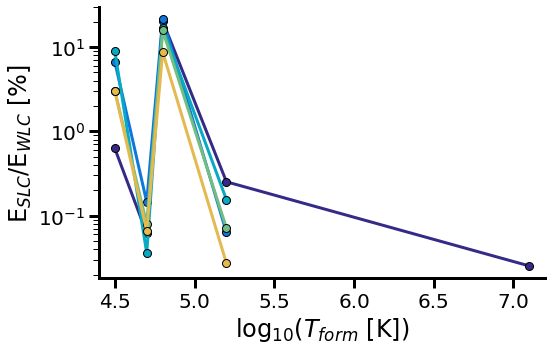

In [49]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

fig, dax = plt.subplots(nrows=1, figsize=(8,5), sharex=True)

strengths = np.array([1.15e-1, 2.24e-1, 3.74e-2, 1.56e-1, 2.79e-3])
letters = ['B', 'D', 'J', 'K', 'M']
ms=8

for i in range(5):#[0,1,2,3,4]:#range(len(energies)):
    q = np.array(energies[i]) > 0
    
    if i < 1:
        scalings = np.array(scalings)
        dax.plot(formtemp[q], (np.array(energies[i])[q]*scalings[q])/wlce[i],
                 c=ion_colors[i], marker='o', lw=3, ms=ms, markeredgecolor='k',
                 label='Flare {}'.format(letters[i]))
    elif i >= 1:
        tempscale = np.array(scalings_25[i-1][:-1])
        dax.plot(formtemp[q][:-1], (np.array(energies[i])[q][:-1]*tempscale)/wlce[i],
                 c=ion_colors[i], marker='o', lw=3, ms=ms, markeredgecolor='k',
                 label='Flare {}'.format(letters[i]))
        print((np.array(energies[i])[q][:-1]*tempscale)/wlce[i])
             

dax.set_xlabel('log$_{10}$($T_{form}$ [K])',fontsize=24)
dax.set_ylabel('E$_{SLC}$/E$_{WLC}$ [%]', fontsize=24)

#dax.legend()
dax.set_xlim(4.4, 7.2)
#dax.set_ylim(2*10e-5,0.7)
dax.set_yscale('log')
#tax.set_ylim(-100,160)

dax.set_rasterized(True)

plt.savefig(os.path.join(path, 'time_energy.png'),
            dpi=300, rasterize=True, bbox_inches='tight',
            transparent=True)

#plt.savefig('/Users/belugawhale/Documents/AUMic/paper/time_energy.pdf',
#            dpi=300, rasterize=True, bbox_inches='tight')

In [51]:
parula[np.linspace(80,230,5,dtype=int)]

array(['#0a97d1', '#1cb3af', '#7fbf7a', '#d4bb58', '#fad22a'], dtype='<U7')

In [59]:
quiescent = np.nanmean(fwc.flux[np.nansum(f_int,axis=0)==0], axis=0)

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70107/616597972.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path, 'spectrum_marked.png'), dpi=300, rasterize=True,


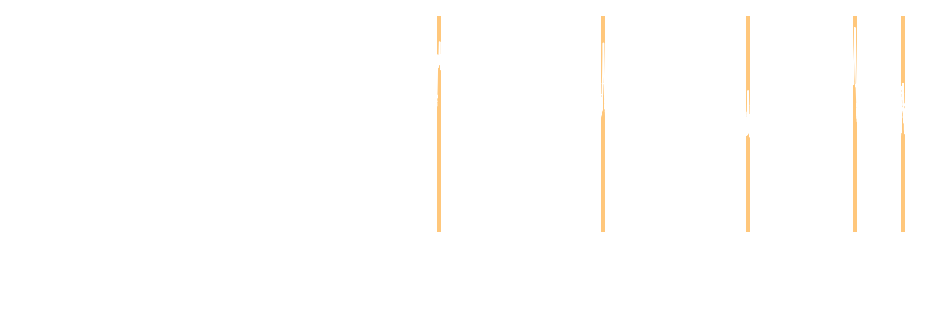

In [106]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

q = ((quiescent>0) & ((fwc.wavelength[0]>=1225) | 
                      (fwc.wavelength[0]<=1200)) & (fwc.wavelength[0]<=1361))
plt.figure(figsize=(14,4))
plt.plot(fwc.wavelength[0][q], quiescent[q], color=COLOR)

for i in ions:
    wave_c = fwc.line_table[fwc.line_table['ion']==i]['wave_c']
    if COLOR == 'k':
        plt.vlines(wave_c, 0, 1, lw=4, color='#A9274A')
    else:
        plt.vlines(wave_c, 0, 1, lw=4, color='#FFC77B')

plt.yscale('log')
plt.xlabel('Wavelength [$\AA$]', fontsize=24)
plt.ylabel('Flux Density\n[erg s$^{-1}$ cm$^{-2} \AA^{-1}$]', fontsize=24)
plt.xlim(1061, 1362)
plt.ylim(10**-18, 10**-12)
plt.savefig(os.path.join(path, 'spectrum_marked.png'), dpi=300, rasterize=True,
            bbox_inches='tight', transparent=True)

In [104]:

for i in ions:
    wave_c = fwc.line_table[fwc.line_table['ion']==i]['wave_c']
    print(i, wave_c[0])

CII_11 1335.708
SiIII 1294.548
CIII 1175.59
NV_1 1238.791
FeXXI 1354.0665


1354.0665
